# Análisis de señales registradas durante sesiones de entrenamiento

Importamos librerías

In [1]:
from SignalProcessor.Filter import Filter
from TrialsHandler.TrialsHandler import TrialsHandler
from SignalProcessor.FeatureExtractor import FeatureExtractor
from SignalProcessor.CSPMulticlass import CSPMulticlass
from SignalProcessor.RavelTransformer import RavelTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cargamos datos

In [2]:
file = "data\sujeto_2\eegdata\sesion1\sn1_ts0_ct1_r1.npy"
rawEEG = np.load(file)

eventosFile = "data\sujeto_2\eegdata\sesion1\sn1_ts0_ct0_r1_events.txt"
eventos = pd.read_csv(eventosFile, sep = ",")

In [3]:
channelsName = ["P3", "P4", "C3", "C4", "F3", "F4", "PZ", "CZ"]
channelsSelected = [0,1,2,3,6,7]
channelsName = [channelsName[i] for i in channelsSelected]

In [4]:
##nos quedamos con los canales seleccionados
rawEEG = rawEEG[channelsSelected,:]
rawEEG.shape

(6, 187500)

### Extrayendo trials

In [5]:
#Definimos el tiempo mínimo y máximo para analizar
tinit = 0 #el tiempo de inicio se considera ANTES del cue
tmax = 4 #el tiempo máximo debe considerarse entre el cue y el final del trial

Usamos la clase _TrialsHandler()_ para extraer los trials, eventos y labels asocaidos al experimento.

Si hay trials a descartar debe armarse una lista y pasarsela al argumento _reject_ de _TrialsHandler()_, caso contrario debe especificarse _None_ (valor por defecto).

In [6]:
fm = 250.
## Instanciamos la clase TrialsHandler para extraer los trials, labels, nombre de clases, etc.
rawdata = TrialsHandler(rawEEG, eventos, tinit = tinit, tmax = tmax, reject=None, sample_rate=fm, trialsToRemove=None)

Se han extraido 75 trials
Se han extraido 6 canales
Se han extraido 1000 muestras por trial


In [7]:
rawdata.eventos.head()

,classNumber,className,prediction,probabilities,startingTime,cueDuration,finishDuration,trialTime,trialTime(legible)
trialNumber,,,,,,,,,
1,5,Rest,-1,-1,3.0,4.0,3.0,1.691529e+09,08/08/2023 18:09:50
2,4,Pies,-1,-1,3.0,4.0,3.0,1.691529e+09,08/08/2023 18:10:00
3,5,Rest,-1,-1,3.0,4.0,3.0,1.691529e+09,08/08/2023 18:10:10
4,3,Ambas Manos,-1,-1,3.0,4.0,3.0,1.691529e+09,08/08/2023 18:10:20
5,4,Pies,-1,-1,3.0,4.0,3.0,1.691529e+09,08/08/2023 18:10:30


### Obtenemos los trials y los labels

In [8]:
trials = rawdata.trials
labels = rawdata.labels

In [9]:
print(trials.shape)
print(labels.shape)

(75, 6, 1000)
(75,)


In [10]:
classesName, classesLabel = rawdata.classesName
print(classesName)
print(classesLabel)

['Mano Izquierda', 'Mano Derecha', 'Ambas Manos', 'Pies', 'Rest']
[1, 2, 3, 4, 5]


In [11]:
##filtramos los trials para las clases que nos interesan estudiar
trials = trials[np.where((labels == 1) | (labels == 2) | (labels == 4))]
labels = labels[np.where((labels == 1) | (labels == 2) | (labels == 4))]
classesLabels = np.unique(labels)

classesName = list(np.array(classesName)[classesLabels-1])

In [12]:
print(trials.shape)
print(labels.shape)

(45, 6, 1000)
(45,)


### Filtramos los trials

In [13]:
fm = 250. #frecuencia de muestreo
filter = Filter(lowcut=8, highcut=18, notch_freq=50.0, notch_width=2, sample_rate=fm, axisToCompute=2, padlen=None, order=8)

In [14]:
trials_mu = filter.fit_transform(trials)

### Extraemos las características con FeatureExtractor y analizar la separabilidad de las clases

En este caso usamos _Welch_

In [15]:
fm = 250.
featureExtractor_welch = FeatureExtractor(method = "welch", sample_rate = fm, axisToCompute=2, band_values=[8,18])

In [16]:
mu_welch = featureExtractor_welch.fit_transform(trials_mu)

In [17]:
print(mu_welch.shape)
print(featureExtractor_welch.freqs)

(45, 6, 10)
[ 8.7890625  9.765625  10.7421875 11.71875   12.6953125 13.671875
 14.6484375 15.625     16.6015625 17.578125 ]


### Separando cada trial con su clase correspondiente

Para este análisis vamos a formar un array de la forma [clase, n_trials, n_channels, n_samples]. Pero es **importante** tener en cuenta que para el entrenamiento de los algoritmos la forma de los datos es [n_trials, n_channels, n_samples].

In [18]:
trials_x_clase = np.zeros((len(np.unique(labels)),int(mu_welch.shape[0]/len(np.unique(labels))), mu_welch.shape[1], mu_welch.shape[2]))

#Por cada label dentro de classNames, filtramos los trials y lo guardamos en la posición correspondiente dentro de trials
for i, label in enumerate(np.unique(labels)):
    trials_x_clase[i,:,:,:] = mu_welch[labels == label]

In [19]:
trials_x_clase.shape

(3, 15, 6, 10)

In [20]:
avg_trials_x_clase = trials_x_clase.mean(axis=1)

### Graficamos estas característcas para un trial n

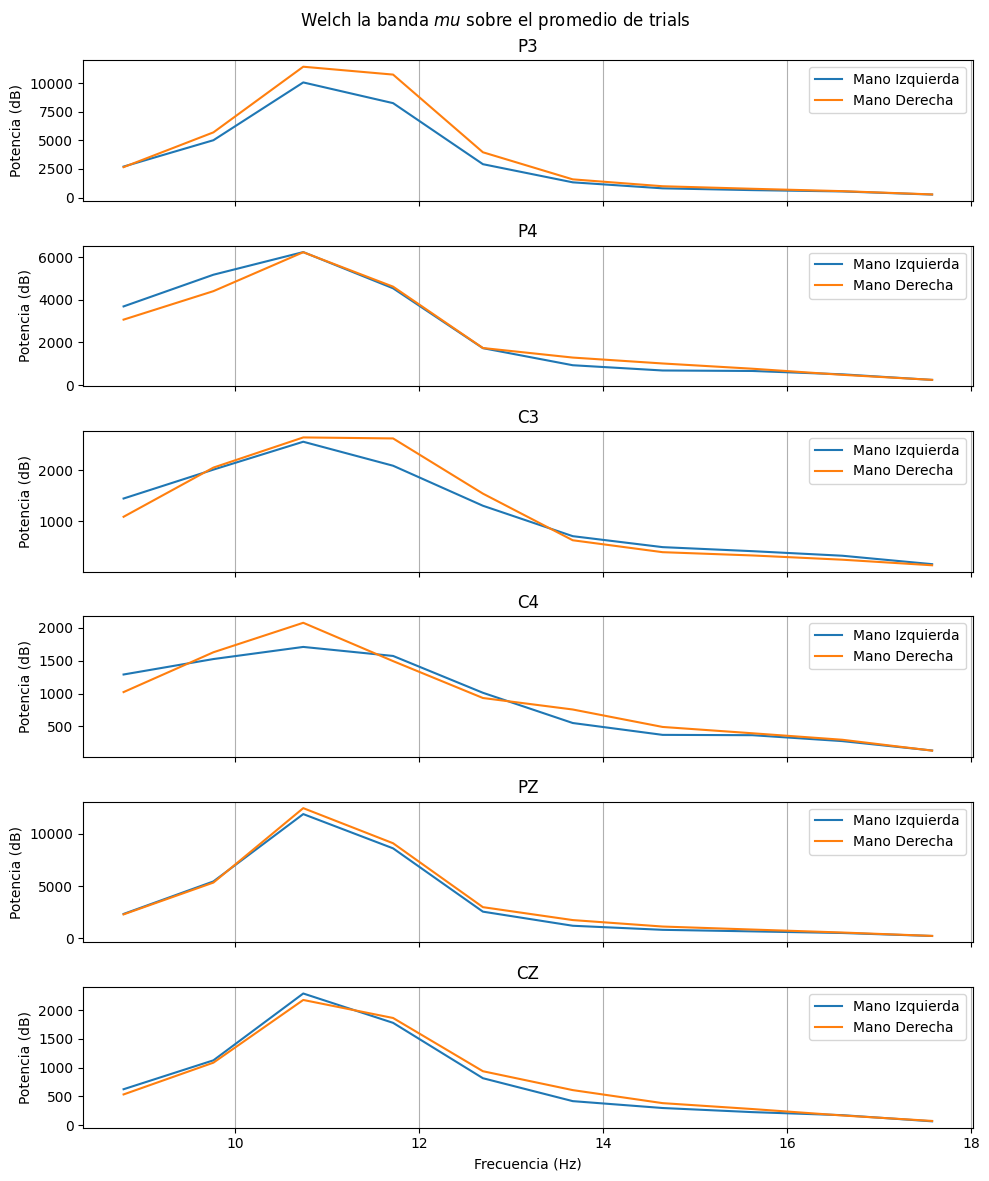

In [21]:
trial = 1
#Estsilo de gráfico default
plt.style.use('default')

fig, axs = plt.subplots(len(channelsSelected), 1, figsize=(10, 12), sharex=True)

for channel, name in enumerate(channelsName):
    axs[channel].plot(featureExtractor_welch.freqs, avg_trials_x_clase[0, channel, :], label=classesName[0])
    axs[channel].plot(featureExtractor_welch.freqs, avg_trials_x_clase[1, channel, :], label=classesName[1])

    # axs[channel].axvspan(8, 12, alpha=0.05, color='grey')
    axs[channel].set_title(name)
    axs[channel].set_ylabel('Potencia (dB)')
    axs[channel].legend()

    #grilla en x
    axs[channel].grid(True, axis='x')

axs[channel].set_xlabel('Frecuencia (Hz)')
plt.suptitle('Welch la banda $mu$ sobre el promedio de trials')
plt.tight_layout()
plt.show()

### Extraemos las características con FeatureExtractor y analizar la separabilidad de las clases

En este caso usamos _Hilbert_

In [22]:
fm = 250.
featureExtractor_hilbert = FeatureExtractor(method = "hilbert", sample_rate = fm)

In [23]:
mu_hilbert = featureExtractor_hilbert.fit_transform(trials_mu)

In [24]:
mu_hilbert.shape

(45, 6, 1000)

In [25]:
trials_x_clase_hilbert = np.zeros((len(np.unique(labels)),int(mu_hilbert.shape[0]/len(np.unique(labels))), mu_hilbert.shape[1], mu_hilbert.shape[2]))

#Por cada label dentro de classNames, filtramos los trials y lo guardamos en la posición correspondiente dentro de trials
for i, label in enumerate(np.unique(labels)):
    trials_x_clase_hilbert[i,:,:,:] = mu_hilbert[labels == label]

In [26]:
avg_trials_x_clase_hilbert = trials_x_clase_hilbert.mean(axis=1)

### Graficamos

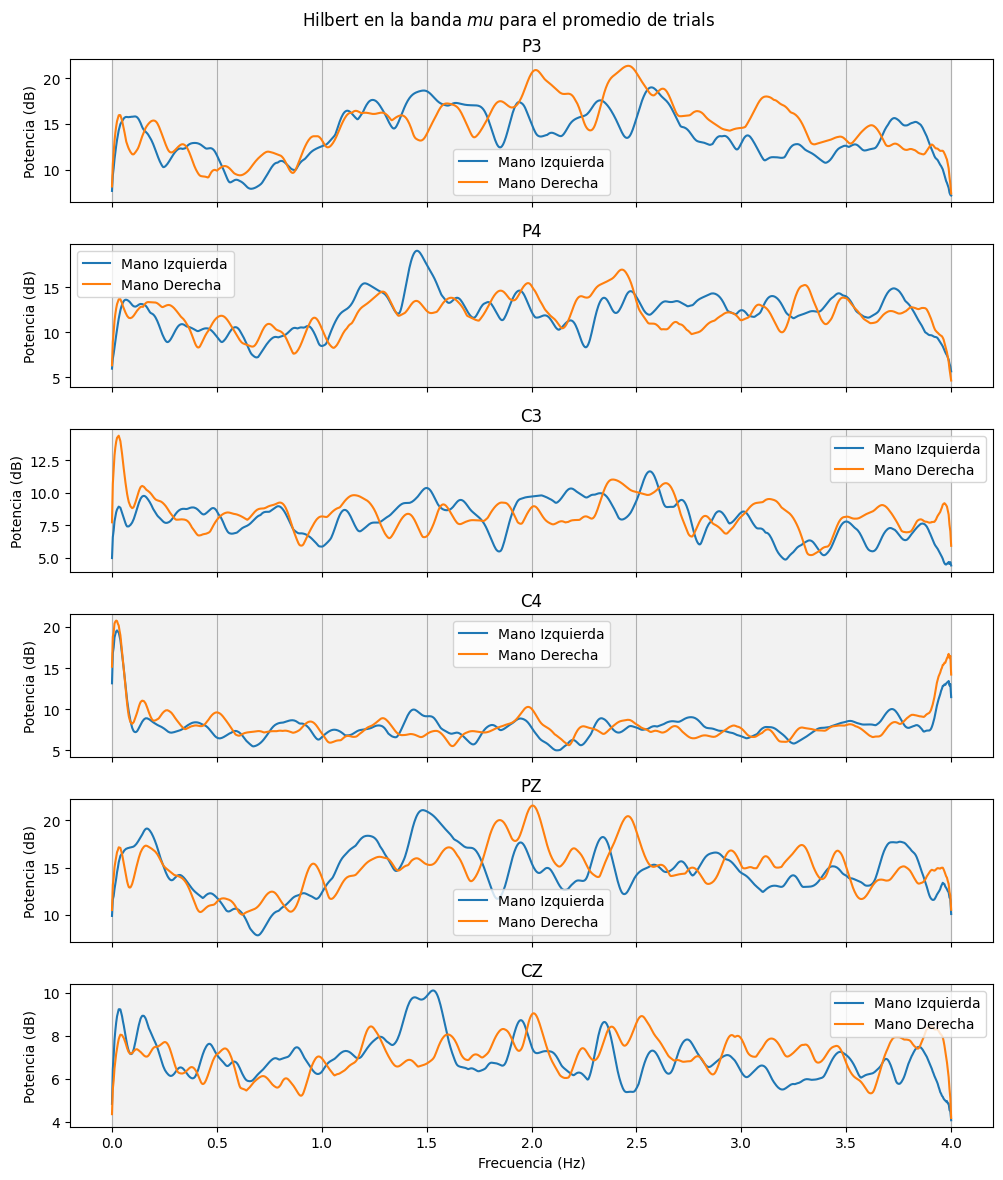

In [95]:
trial = 2
#Estsilo de gráfico default
plt.style.use('default')

timeline = np.linspace(-tinit, tmax, mu_hilbert.shape[2])

fig, axs = plt.subplots(len(channelsSelected), 1, figsize=(10, 12), sharex=True)

for channel, name in enumerate(channelsName):
    axs[channel].plot(timeline, avg_trials_x_clase_hilbert[0, channel,:], label=classesName[0])
    axs[channel].plot(timeline, avg_trials_x_clase_hilbert[1, channel,:], label=classesName[1])

    axs[channel].axvspan(0, 4, alpha=0.1, color='grey')

    axs[channel].set_title(name)
    axs[channel].set_ylabel('Potencia (dB)')
    axs[channel].legend()

    #grilla en x
    axs[channel].grid(True, axis='x')

axs[channel].set_xlabel('Frecuencia (Hz)')
plt.suptitle('Hilbert en la banda $mu$ para el promedio de trials')
plt.tight_layout()
plt.show()

### Aplicando CSP

In [28]:
## Separamos en train y test
from sklearn.model_selection import train_test_split

#separamos en train y test. Balanceamos las clases
X_train, X_test, y_train, y_test = train_test_split(trials_mu, labels, test_size=0.2, random_state=42, stratify=labels)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36, 6, 1000)
(9, 6, 1000)
(36,)
(9,)


In [71]:
n_components = 1
cspmulticlass = CSPMulticlass(n_components = n_components, method = "ovo", n_classes = len(np.unique(labels)), reg = 0.01)

In [72]:
cspmulticlass.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 2.9 (2.2e-16 eps * 6 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 6 dim * 2e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.7 (2.2e-16 eps * 6 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 6 dim * 2e+15  max singular value)
    Estimated rank (mag): 6
    MAG: ra

CSPMulticlass(n_classes=3, n_components=1, reg=0.01)

### Analizando la señal luego de haber aplicado el CSP

In [96]:
X_test_csp = cspmulticlass.transform(X_test)

In [97]:
X_test_csp.shape

(9, 3, 1000)

Extraemos características

In [75]:
fm = 250.
featureExtractor_welch = FeatureExtractor(method = "welch", sample_rate = fm, axisToCompute=2, band_values=[5,18])

In [76]:
X_test_csp_welch = featureExtractor_welch.fit_transform(X_test_csp)
X_test_csp_welch.shape

(9, 3, 13)

### Usamos RavelTransformer() para concatenar features

In [77]:
raveltransformer = RavelTransformer() #instanciamos el raveltransformer

X_test_csp_welch_ravel = raveltransformer.fit_transform(X_test_csp_welch)
print(X_test_csp_welch_ravel.shape)

(9, 39)


Separamos por clase

In [78]:
x_clase_X_test_csp_welch = np.zeros((len(np.unique(labels)),int(X_test_csp_welch_ravel.shape[0]/len(np.unique(labels))), X_test_csp_welch_ravel.shape[1]))

#Por cada label dentro de classNames, filtramos los trials y lo guardamos en la posición correspondiente dentro de trials
for i, label in enumerate(np.unique(labels)):
    x_clase_X_test_csp_welch[i,:] = X_test_csp_welch_ravel[y_test == label]

In [79]:
x_clase_X_test_csp_welch.shape #shape [clase, componente, features]

(3, 3, 39)

In [80]:
avg_x_clase_X_test_csp_welch= x_clase_X_test_csp_welch.mean(axis=1)

In [81]:
avg_x_clase_X_test_csp_welch.shape

(3, 39)

Text(0.5, 1.0, 'Feature de las componentes concatenadas')

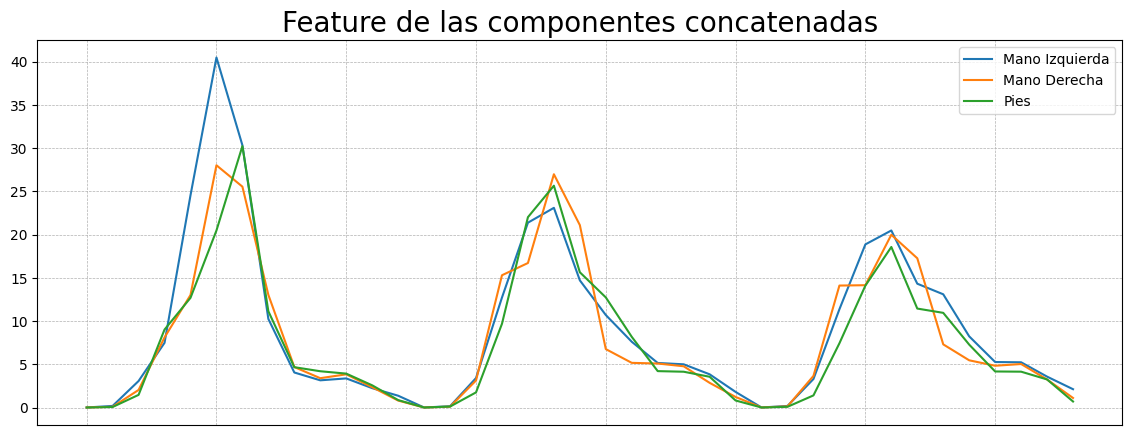

In [94]:
### Estsilo de gráfico default
plt.style.use('default')

fig, ax = plt.subplots(figsize=(14, 5))

for i, clase in enumerate(classesName):
    ax.plot(avg_x_clase_X_test_csp_welch[i,:], label=clase)

##turn off the values of the x axis but make the ticks visibles
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
##grillas x e y
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.grid(True, axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.title("Feature de las componentes concatenadas", fontsize=20)
    

## Analizando componentes del CSP en 